# Testing the DEWFluid 'coder' module

In [1]:
import numpy as np
from thermoengine import phases
from thermoengine import model
import pyDEW
import dill
#%run core.ipynb
import importlib
import matplotlib.pyplot as plt


/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/pyximport/pyximport.py:51: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Create the DEWFluid phase object
This imports the manually created coder python module. This is not a coder produced module, but ENKI will treat it as though it is.

In [3]:
DEWFluid = phases.SolutionPhase('DEWFluid_', 'DEW', calib=False, source='coder',coder_module='DEWFluid_module')

Module generated by the coder package does not yet provide a formula method.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.


The system properties are currently hard-coded into the module, the system is set up with the elements:

In [4]:
elements = ['O', 'H', 'Si', 'Na', 'Cl']
basis_species = ['H2O', 'H+', 'H4SIO4(AQ)', 'NA+', 'CL-', 'O2(G)']
other_species = ['H6SI2O7(AQ)', 'H8SI3O10(AQ)', 'H3SIO4-', 'OH-', 'O2(AQ)', 'NACL(AQ)', 'NAOH(AQ)', 'HCL(AQ)']
# elements = pyQ3.defaultsystem.elements
# basis_species = pyQ3.defaultsystem.basis_species_names
# other_species = pyQ3.defaultsystem.other_species_names
sys = pyDEW.System(elements=elements, basis_species=basis_species, other_species=other_species)
sys.elements

['O', 'H', 'Si', 'Na', 'Cl']

Demo call to the gibbs_energy function.

In [5]:
moles = np.array([np.nan,  # O
                  0.9,     # H
                  0.04,    # Si
                  0.025,     # Na
                  0.025,    # Cl
                  ])

# moles = np.array([0.5+0.04,
#                   1.0+0.04,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.01,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0])

# moles = moles/np.sum(moles)
moles

array([  nan, 0.9  , 0.04 , 0.025, 0.025])

In [6]:
DEWFluid.gibbs_energy(573,10000,mol=moles)

-145161.79926002756

In [7]:
output = pyDEW.output.eq3output('eq_working/output')

In [8]:
output.elemental_comp

,element,ppm,molality
0,O,1214471.9539,.7590734364E+02
1,H,129917.5675,.1288992633E+03
2,SI,160897.7852,.5728856000E+01
3,NA,82315.6761,.3580535000E+01
4,CL,126940.7074,.3580535000E+01


In [9]:
output.basis_species_comp

,species,ppm,molality
0,H2O,1367485.9772,75.907344
1,H+,129917.5675,128.899263
2,H4SIO4,550627.2758,5.728856
3,NA+,82315.6761,3.580535
4,CL-,126940.7074,3.580535


In [10]:
output.basis_species_comp

,species,ppm,molality
0,H2O,1367485.9772,75.907344
1,H+,129917.5675,128.899263
2,H4SIO4,550627.2758,5.728856
3,NA+,82315.6761,3.580535
4,CL-,126940.7074,3.580535


In [11]:
output.aqueous_species

,species,molality,log_g,activity
0,NA+,2.963000e+00,-0.2992,1.488000e+00
1,CL-,2.962000e+00,-0.2992,1.488000e+00
2,H6SI2O7(AQ),2.516000e+00,0.0000,2.516000e+00
3,H4SIO4(AQ),6.948000e-01,0.0000,6.948000e-01
4,NACL(AQ),6.180000e-01,0.0000,6.180000e-01
5,H3SIO4-,6.181000e-04,-0.2992,3.104000e-04
6,H+,3.827000e-04,-0.2992,1.922000e-04
7,HCL(AQ),2.810000e-04,0.0000,2.810000e-04
8,H8SI3O10(AQ),1.578000e-04,0.0000,1.578000e-04
9,OH-,3.069000e-05,-0.2992,1.541000e-05


# Testing the free energy
Hopefully the calculation is sufficiently precise that we can generate smooth values of the free energy. Here I demonstrate the variation of the solution free energy as salinity is increased.

In [7]:
NaCl_fractions = np.logspace(-4,-0.5,10)
SiO2 = 0.01

mol_fractions = list()

for i in range(np.shape(NaCl_fractions)[0]):
    mols = np.zeros(len(elements))
    mols[0] = 2/3*(1 + 4*SiO2)
    mols[1] = 1/3*(1 + 4*SiO2)
    mols[2] = SiO2
    mols[3] = NaCl_fractions[i]
    mols[4] = NaCl_fractions[i]
    mols = mols/np.sum(mols)
    mol_fractions.append(mols)

free_energies = []

for i in range(np.shape(NaCl_fractions)[0]):
    free_energies.append(DEWFluid.gibbs_energy(573,10000,mol=mol_fractions[i]))



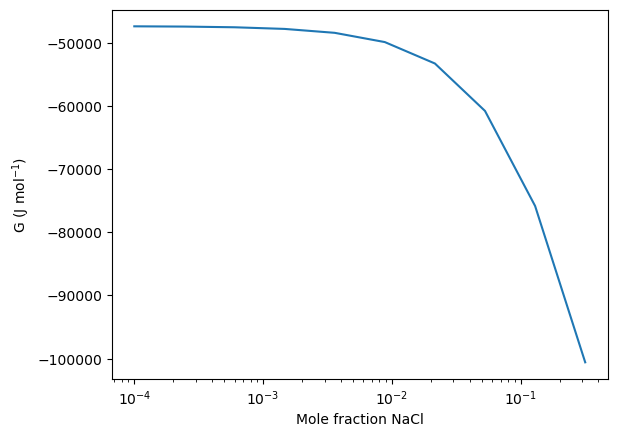

In [8]:
f,a = plt.subplots()
a.plot(NaCl_fractions,free_energies)
a.set_xscale('log')
a.set_ylabel(r'G (J mol$^{-1}$)')
a.set_xlabel('Mole fraction NaCl')
plt.show()

## Testing the first derivative
Testing the derivative is slightly less straightforward. Ideally we want to be able to plot a free energy curve as a reference point for the general behaviour of the derivative, in addition to checking the derivative is smooth. Smoothness is important as this will be controlled by the precision of the calculation and the precision of the output file. The derivatives are controlled by variations in a single component, e.g. Cl.


In [6]:
Si_fractions = np.linspace(0.0001,0.1,20)

mol_fractions = list()

for i in range(np.shape(Si_fractions)[0]):
    mols = np.zeros(len(elements))
    mols[0] = 6 + Si_fractions[i]*4
    mols[1] = 3 + Si_fractions[i]*4
    mols[2] = Si_fractions[i]
    mols[3] = 0.001
    mols[4] = 0.001
    mols = mols/np.sum(mols)
    mol_fractions.append(mols)

free_energies = []
dgdn = np.zeros([np.shape(Si_fractions)[0],len(elements)])
d2gdn2 = np.zeros([np.shape(Si_fractions)[0],len(elements),len(elements)])
# dgdSi = list()

for i in range(np.shape(Si_fractions)[0]):
    print(i)
    try:
        free_energies.append(DEWFluid.gibbs_energy(573,10000,mol=mol_fractions[i]))
    except:
        free_energies.append(np.nan)

    dgdn[i,:] = DEWFluid.gibbs_energy(573,10000,mol=mol_fractions[i],deriv={'dmol':1})

    # try:
    #     d2gdn2[i,:,:] = DEWFluid.gibbs_energy(573,10000,mol=mol_fractions[i],deriv={'dmol':2})
    # except:
    #     pass


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


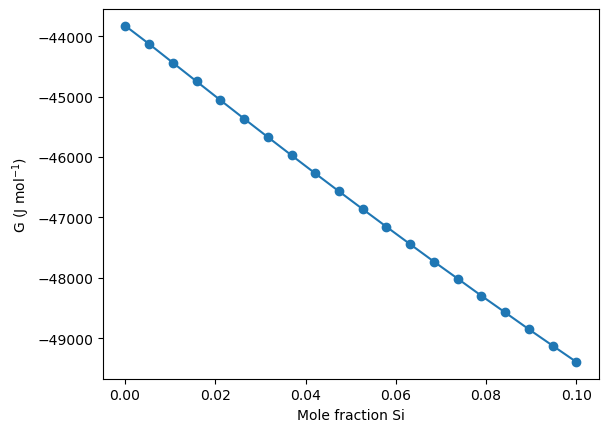

In [ ]:
f,a = plt.subplots()
a.plot(Si_fractions, free_energies, marker='o')
# a.set_xscale('log')
a.set_ylabel(r'G (J mol$^{-1}$)')
a.set_xlabel('Mole fraction Si')
plt.show()

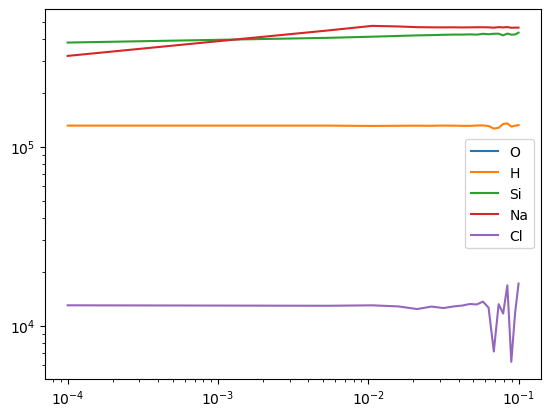

In [8]:
f,a = plt.subplots()
for i in range(len(elements)):
    a.plot(Si_fractions,-dgdn[:,i],label=elements[i])
# a.plot(Si_fractions,dgdn[:,2], marker='o',label=elements[2])
# a.plot(Si_fractions[1:],dgdSi,ls='--')
a.set_xscale('log')
a.set_yscale('log')
a.legend()
plt.show()

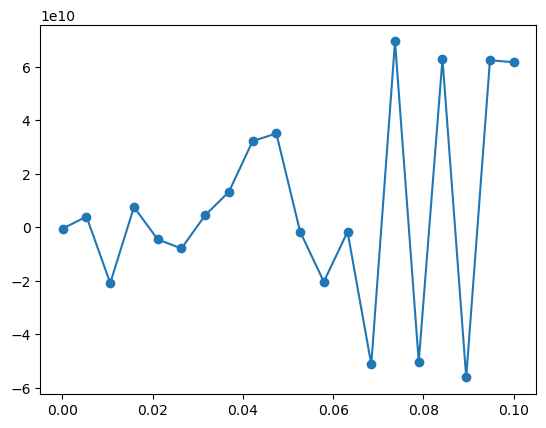

In [22]:
f,a = plt.subplots()
# for i in range(len(elements)):
#     a.plot(Si_fractions,dgdn[:,i],label=elements[i])

a.plot(Si_fractions,d2gdn2[:,2,2], marker='o')

# a.plot(Si_fractions,-d2gdn2[:,2,2])
# a.plot(Si_fractions[1:],dgdSi,ls='--')
# a.set_xscale('log')
# a.set_yscale('log')
# a.legend()
plt.show()

## Test in the Equilibrate algorithm

In [48]:
from thermoengine import core, equilibrate

In [5]:
elm_sys = ['O', 'H', 'Si']
elm_sys

['O', 'H', 'Si']

In [6]:
phs_sys = [DEWFluid]

In [7]:
mol_elm = [2.04, 1.04, 0.01]
# mol_elm = [1.4, 2.4, 0.1, 0.01, 0.01]
mol_elm = mol_elm/np.sum(mol_elm)
mol_elm

array([0.66019417, 0.33656958, 0.00323625])

In [8]:
blk_cmp = mol_elm

### Simple Equilibrate run- no fO2 constraint- only DEW

In [9]:
equil = equilibrate.Equilibrate(elm_sys, phs_sys)

In [10]:
t = 723.15
p = 10000.0
state = equil.execute(t, p, bulk_comp=blk_cmp, debug=3, stats=True)
state.print_state()

DEW is the omnicomponent phase.
Stable phase assemblage computed. Exiting.
 
T =     450.00 °C, P =     1000.0 MPa
DEW             moles:   1.000000 grams:   6.141
              O form:  O              X:  0.3366  wt%    SiO2    3.17
              H form:  H              X:  0.6602  wt%     H2O   96.83
             Si form:  Si             X:  0.0032  


In [11]:
state.dGdn()

array([[ 330659.8871397 ],
       [ 380226.14947326],
       [-713069.39279507]])

### Add in fO2 constraint

In [74]:
def muO2_std(t, p):
        tr = 298.15
        hs = 23.10248*(t-tr) + 2.0*804.8876*(np.sqrt(t)-np.sqrt(tr)) - 1762835.0*(1.0/t-1.0/tr) \
           - 18172.91960*np.log(t/tr) + 0.5*0.002676*(t*t-tr*tr)
        ss = 205.15 + 23.10248*np.log(t/tr)  - 2.0*804.8876*(1.0/np.sqrt(t)-1.0/np.sqrt(tr)) \
           - 0.5*1762835.0*(1.0/(t*t)-1.0/(tr*tr)) + 18172.91960*(1.0/t-1.0/tr) + 0.002676*(t-tr)
        return hs - t*ss + 205.15*298.15

def muO2(t, p, state):
    std = muO2_std(t, p)
    mu = std + 8.314*t*np.log(10**-12.0)
    return mu

In [75]:
muO2(100.0, 1000.0, None)

14529.923494307459

In [76]:
equil = equilibrate.Equilibrate(elm_sys, phs_sys, lagrange_l=[({'O':2.0},muO2)]) 

In [77]:
t = 723.15
p = 10000.0
state = equil.execute(t, p, bulk_comp=blk_cmp, debug=3, stats=True)
state.print_state()

CTf (1, 5)
[[0. 2. 0. 0. 0.]]
A_omni_inv (5, 5)
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
U (5, 5)
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
S (5,)
[2. 0. 0. 0. 0.]
VT (5, 5)
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]
VT null space (4, 5)
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]
DEW is the omnicomponent phase.
******************************** 
Calculating saturation state for Quartz
Target chemical potentials:  [-883475.17789991]
-883475.1778999148 -864111.672609022
Affinity, mole fraction 19363.50529089279 [1.]
 
******************************** 
Calculating saturation state for Coesite
Target chemical potentials:  [-883475.17789991]
-883475.1778999148 -860324.9675752182
Affinity, mole fraction 23150.210324696614 [1.]
 
Zero element projection matrix (5, 5)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]

In [83]:
DEWFluid.chem_potential(450+273.15, 10000.0, mol=mol_elm)

array([121746.20621257])

In [87]:
DEWFluid.gibbs_energy(450+273.15, 10000.0, mol=[2.04, 1.04, 1e-11, 0.1, 1e-11], deriv={'dmol':1})

array([[      0.        , -136052.38984209, -905629.33359101,
        -567622.25081597,  119472.07848746]])

In [86]:
qz.chem_potential(450+273.15, 10000.0)

-864111.672609022

### Try simple calculation with quartz

In [41]:
berman = model.Database()

In [42]:
qz = berman.get_phase('Qz')
coe = berman.get_phase('Coe')

In [43]:
qz.enable_gibbs_energy_reference_state()
coe.enable_gibbs_energy_reference_state()

In [64]:
mol_elm = [2.04, 1.04, 1e-11, 0.5, 1e-11]
# mol_elm = [1.4, 2.4, 0.1, 0.01, 0.01]
mol_elm = mol_elm/np.sum(mol_elm)
mol_elm

array([5.69832402e-01, 2.90502793e-01, 2.79329609e-12, 1.39664804e-01,
       2.79329609e-12])

In [65]:
blk_cmp = mol_elm

In [66]:
phs_sys = [DEWFluid, qz, coe]
elm_sys = ['H', 'O', 'Si', 'Na', 'Cl']

In [67]:
equil = equilibrate.Equilibrate(elm_sys, phs_sys)

In [68]:
t = 400.0 + 273.15
p = 1000.0
state = equil.execute(t, p, bulk_comp=blk_cmp, debug=3, stats=True)
state.print_state()

DEW is the omnicomponent phase.
******************************** 
Calculating saturation state for Quartz
Target chemical potentials:  [-898659.85883497]
-898659.8588349702 -880041.1301162987
Affinity, mole fraction 18618.728718671482 [1.]
 
******************************** 
Calculating saturation state for Coesite
Target chemical potentials:  [-898659.85883497]
-898659.8588349702 -874508.9640812244
Affinity, mole fraction 24150.894753745757 [1.]
 
Stable phase assemblage computed. Exiting.
 
T =     400.00 °C, P =      100.0 MPa
DEW             moles:   1.000000 grams:   9.145
              O form:  O              X:  0.2905  wt%    SiO2   62.05
              H form:  H              X:  0.5698  wt%    Na2O    0.00
             Si form:  Si             X:  0.1397  wt%     H2O   37.95
             Na form:  Na             X:  0.0000  
             Cl form:  Cl             X:  0.0000  
Quartz          affn:   18618.73
Coesite         affn:   24150.89


In [69]:
DEWFluid.test_endmember_comp(mol_elm)

True

In [70]:
state.moles_elements('DEW')

array([5.69832402e-01, 2.90502793e-01, 2.79329609e-12, 1.39664804e-01,
       2.79329609e-12])

In [73]:
state.dGdn(t=400+273.15, p=1000.0)

array([[-104263.10984826],
       [      0.        ],
       [-612501.54004293],
       [-898659.85883497],
       [ -59320.16277963]])